In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import yfinance as yf
from talib import abstract

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

# SK-learn libraries for data processing and learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# directly import strategies
SMA = abstract.SMA
EMA = abstract.EMA
MACD = abstract.MACD
RSI = abstract.RSI
STOCH = abstract.STOCH
STOCHRSI = abstract.STOCHRSI

C:\ProgramData\Anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Download Data

In [2]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
stock = yf.Ticker("SPY")

# one way to get data for period of interest
raw_data = stock.history(period="16y")
raw_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-03-21,86.322266,86.373168,85.631458,85.878693,61244300,0.000,0
2005-03-22,86.075020,86.482233,85.006081,85.006081,92472400,0.000,0
2005-03-23,85.042443,85.602367,84.897012,85.078804,70817300,0.000,0
2005-03-24,85.413297,85.798696,85.122428,85.180603,51932500,0.000,0
2005-03-28,85.384211,85.762342,85.304222,85.304222,46765500,0.000,0
...,...,...,...,...,...,...,...
2021-03-15,393.042679,395.394990,390.750200,395.115906,73427200,0.000,0
2021-03-16,395.773740,396.531238,393.790216,394.617523,72958000,0.000,0
2021-03-17,393.242036,396.820313,392.016040,395.963135,91822000,0.000,0


In [3]:
def add_features(data):
    """Add all features needed to a dataset for the logistic regression model"""
    df = data.copy()
    
    # Daily return based on Close price
    df["Return"] = df["Close"] - df["Close"].shift(1)
    df["Return%"] = df["Return"] / df["Close"].shift(1)

    # Last 5 day return based on Close price
    df["L5D_Return"] = df["Close"] - df["Close"].shift(5)
    df["L5D_Return%"] = df["L5D_Return"] / df["Close"].shift(5)

    # Next 5 day return based on Close price
    df["N5D_Return"] = (df["Close"] - df["Close"].shift(-5)) * -1
    df["N5D_Return%"] = df["N5D_Return"] / df["Close"]

    # Next 5 day return based on Open price next day
    df["N5D_Return_Delayed"] = (df["Open"].shift(-1) - df["Close"].shift(-5)) * -1
    df["N5D_Return_Delayed%"] = df["N5D_Return_Delayed"] / df["Open"].shift(-1)

    # Close price as a % of 52-Week high and low
    df["52Wk_High"] = df["Close"].rolling(min_periods=252, window=252).max()
    df["52Wk_Low"] = df["Close"].rolling(min_periods=252, window=252).min()
    df["%52Wk_High"] = df["Close"] / df["52Wk_High"]
    df["%52Wk_Low"] = df["Close"] / df["52Wk_Low"]

    # Open price as a % of prior Close
    df["Open%PriorClose"] = df["Open"] / df["Close"].shift(1)

    # Close price as a % of Open, High, and Low
    df["Close%Open"] = df["Close"] / df["Open"]
    df["Close%High"] = df["Close"] / df["High"]
    df["Close%Low"] = df["Close"] / df["Low"]

    # Dividend as a % of Close
    df["Div%Close"] = df["Dividends"] / df["Close"]

    # Volume as a % of 52-Week average volume
    df["52Wk_Avg_Volume"] = df["Volume"].rolling(min_periods=252, window=252).mean()
    df["%52Wk_Avg_Volume"] = df["Volume"] / df["52Wk_Avg_Volume"]

    # Add simple moving averages (SMAs)
    df["SMA3"] = SMA(df.Close, 3)
    df["SMA5"] = SMA(df.Close, 5)
    df["SMA10"] = SMA(df.Close, 10)
    df["SMA15"] = SMA(df.Close, 15)
    df["SMA20"] = SMA(df.Close, 20)
    df["SMA30"] = SMA(df.Close, 30)
    df["SMA50"] = SMA(df.Close, 50)

    # Standardized % above or below simple trading averages
    df["SMA3%"] = df["Close"] / df["SMA3"] - 1
    df["SMA5%"] = df["Close"] / df["SMA5"] - 1
    df["SMA10%"] = df["Close"] / df["SMA10"] - 1
    df["SMA15%"] = df["Close"] / df["SMA15"] - 1
    df["SMA20%"] = df["Close"] / df["SMA20"] - 1
    df["SMA30%"] = df["Close"] / df["SMA30"] - 1
    df["SMA50%"] = df["Close"] / df["SMA50"] - 1

    # Add exponential moving averages (EMAs)
    # More info: https://www.investopedia.com/terms/e/ema.asp
    df["EMA3"] = EMA(df.Close, 3)
    df["EMA5"] = EMA(df.Close, 5)
    df["EMA10"] = EMA(df.Close, 10)
    df["EMA15"] = EMA(df.Close, 15)
    df["EMA20"] = EMA(df.Close, 20)
    df["EMA30"] = EMA(df.Close, 30)
    df["EMA50"] = EMA(df.Close, 50)

    # Standardized % above or below exponential trading averages
    df["EMA3%"] = df["Close"] / df["EMA3"] - 1
    df["EMA5%"] = df["Close"] / df["EMA5"] - 1
    df["EMA10%"] = df["Close"] / df["EMA10"] - 1
    df["EMA15%"] = df["Close"] / df["EMA15"] - 1
    df["EMA20%"] = df["Close"] / df["EMA20"] - 1
    df["EMA30%"] = df["Close"] / df["EMA30"] - 1
    df["EMA50%"] = df["Close"] / df["EMA50"] - 1

    # Add pivot point (PP) and classical support and resistance pivot points
    # More info: https://www.investopedia.com/terms/p/pivotpoint.asp
    df["PP"] = (df.High + df.Low + df.Close) / 3
    df["S1C"] = df.PP * 2 - df.High
    df["S2C"] = df.PP - (df.High - df.Low)
    df["S3C"] = df.Low - 2 * (df.High - df.PP)
    df["R1C"] = df.PP * 2 - df.Low 
    df["R2C"] = df.PP + (df.High - df.Low)
    df["R3C"] = df.High + 2 * (df.PP - df.Low)

    # Standardized % above or below classical pivot points
    df["PP%"] = df["Close"] / df["PP"] - 1
    df["S1C%"] = df["Close"] / df["S1C"] - 1
    df["S2C%"] = df["Close"] / df["S2C"] - 1
    df["S3C%"] = df["Close"] / df["S3C"] - 1
    df["R1C%"] = df["Close"] / df["R1C"] - 1
    df["R2C%"] = df["Close"] / df["R2C"] - 1
    df["R3C%"] = df["Close"] / df["R3C"] - 1

    # Add Fibonacci support and resistance pivot points
    # More info: https://www.interactivebrokers.com/en/software/tws/usersguidebook/
    #technicalanalytics/fibonaccipivotpoints.htm
    df["S1F"] = df.PP - 0.382 * (df.High - df.Low)
    df["S2F"] = df.PP - 0.618 * (df.High - df.Low)
    df["S3F"] = df.PP - 1.0 * (df.High - df.Low)
    df["R1F"] = df.PP + 0.382 * (df.High - df.Low)
    df["R2F"] = df.PP + 0.618 * (df.High - df.Low)
    df["R3F"] = df.PP + 1.0 * (df.High - df.Low)

    # Standardized % above or Fibonacci classical pivot points
    df["S1F%"] = df["Close"] / df["S1F"] - 1
    df["S2F%"] = df["Close"] / df["S2F"] - 1
    df["S3F%"] = df["Close"] / df["S3F"] - 1
    df["R1F%"] = df["Close"] / df["R1F"] - 1
    df["R2F%"] = df["Close"] / df["R2F"] - 1
    df["R3F%"] = df["Close"] / df["R3F"] - 1

    # Add SMA Crossing Signal
    sma_fast = SMA(df.Close, 3)
    sma_slow = SMA(df.Close, 15)
    sma_signal = pd.Series(sma_fast > sma_slow).astype(int).diff().fillna(0)
    df["SMA_Signal"] = sma_signal.values

    # Add MACD Signal
    macd, macdsignal, macdhist = MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)
    macd_signal = pd.Series(macd > macdsignal).astype(int).diff().fillna(0)
    df["MACD_Signal"] = macd_signal.values

    # Add RSI Level and Signal
    real = RSI(df.Close, timeperiod=14)
    df["RSI"] = real
    overbought = 70
    oversold = 30
    buy_signal = pd.Series(real <= oversold).astype(int)
    sell_signal = pd.Series(real >= overbought).astype(int) * -1
    rsi_signal = buy_signal + sell_signal
    df["RSI_Signal"] = rsi_signal.values

    # Add Stochastic Oscillator levels
    slowk, slowd = STOCH(df.High, df.Low, df.Close, 
                         fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    overbought = 80
    oversold = 20
    buy_signal = pd.Series(slowk <= oversold).astype(int) + pd.Series(slowd <= oversold).astype(int)
    sell_signal = pd.Series(slowk >= overbought).astype(int) * -1 + pd.Series(slowd >= overbought).astype(int) * -1
    stoch_signal = buy_signal + sell_signal
    df["Slow_K"] = slowk
    df["Slow_D"] = slowd
    df["Stoch_Osci"] = stoch_signal.values

    # Add Stochastic RSI levels
    fastk, fastd = STOCHRSI(df.Close, timeperiod=14, fastk_period=14, fastd_period=3, fastd_matype=0)
    overbought = 80
    oversold = 20
    buy_signal = pd.Series(fastk <= oversold).astype(int) + pd.Series(fastd <= oversold).astype(int)
    sell_signal = pd.Series(fastk >= overbought).astype(int) * -1 + pd.Series(fastd >= overbought).astype(int) * -1
    stoch_signal = buy_signal + sell_signal
    df["Fast_K"] = fastk
    df["Fast_D"] = fastd
    df["Stoch_RSI"] = stoch_signal.values

    return df

In [4]:
def normalize_features(df):
    """Get the normalized features from the data frame"""
    
    # Only use standardized features for model
    data = df[['Stock Splits', 'Return%', 'L5D_Return%', \
           '%52Wk_High','%52Wk_Low', 'Open%PriorClose', \
           'Close%Open', 'Close%High', 'Close%Low','Div%Close', \
           'SMA3%', 'SMA5%', 'SMA10%', 'SMA15%', 'SMA20%', 'SMA30%', 'SMA50%', \
           'EMA3%', 'EMA5%', 'EMA10%', 'EMA15%', 'EMA20%', 'EMA30%', 'EMA50%', \
           'PP%', 'S1C%', 'S2C%','S3C%', 'R1C%', 'R2C%', 'R3C%', \
           'S1F%', 'S2F%', 'S3F%', 'R1F%', 'R2F%', 'R3F%', \
           'SMA_Signal', 'MACD_Signal', 'RSI', 'RSI_Signal', 'Slow_K', 'Slow_D', \
           'Stoch_Osci', 'Fast_K', 'Fast_D', 'Stoch_RSI']]

    # Scale all features between 0 and 1
    norm = MinMaxScaler().fit(data)
    norm_data = pd.DataFrame(norm.transform(data), columns=data.columns)

    # Rename the "Stock Split" column
    norm_data.rename(columns={'Stock Splits': 'Stock_Splits_norm'}, inplace=True)
    
    return norm_data

In [68]:
norm_data.tail()

,Stock_Splits_norm,Return%,L5D_Return%,%52Wk_High,%52Wk_Low,Open%PriorClose,Close%Open,Close%High,Close%Low,Div%Close,...,SMA_Signal,MACD_Signal,RSI,RSI_Signal,Slow_K,Slow_D,Stoch_Osci,Fast_K,Fast_D,Stoch_RSI
3767,0.0,0.410197,0.453500,0.945977,0.929044,0.646339,0.485067,0.844065,0.006206,0.0,...,0.5,0.5,0.435164,0.5,0.400791,0.340330,0.50,0.246809,0.190486,0.75
3768,0.0,0.485824,0.509130,0.972939,0.960382,0.695399,0.550307,0.928722,0.038089,0.0,...,0.5,0.5,0.515633,0.5,0.578956,0.432568,0.50,0.556953,0.376137,0.50
3769,0.0,0.454197,0.559552,0.984862,0.974240,0.669401,0.528470,0.952834,0.028661,0.0,...,1.0,0.5,0.548155,0.5,0.692079,0.562492,0.50,0.686078,0.496613,0.50
3770,0.0,0.469571,0.618954,1.000000,0.996953,0.671171,0.549678,0.945650,0.036054,0.0,...,0.5,1.0,0.598427,0.5,0.839182,0.711103,0.25,0.858191,0.700407,0.25
3771,0.0,0.435040,0.574334,1.000000,1.000000,0.607772,0.560063,0.996141,0.057685,0.0,...,0.5,0.5,0.605040,0.5,0.902175,0.820672,0.00,0.880828,0.808366,0.00


In [52]:
def generate_model_data(df, metric="N5D_Return_Delayed%", buy_threshold=0.01, sell_threshold=-0.002):
    """
    Generate regression model data from a ticker download from yfinance.
    buy_threshold is the return threshold for labelling "buy".
    sell_threshold is the return threshold for labelling "sell".
    metric is the return metric used.
    
    """
    
    # Generate features
    data = add_features(df)
    
    # Drop NA rows where metrics cannot be computed (beginning and end of the dataframe)
    # Drops about a year plus a few days of data
    data = data.dropna(axis=0, how='any')
    
    # Generate labels
    return_metric = data[metric]
    
    buy_signal = pd.Series(return_metric >= buy_threshold).astype(int)
    sell_signal = pd.Series(return_metric <= sell_threshold).astype(int) * -1
    labels = buy_signal + sell_signal
    
    # Generate normalized model data
    norm_data = normalize_features(data)
    
    return norm_data, labels

In [21]:
## Generate model data
norm_data, labels = generate_model_data(raw_data)

print(norm_data.shape)
print(labels.shape)

(3772, 47)
(3772,)


(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 8.000e+00, 3.000e+01, 8.200e+01, 3.790e+02,
        2.288e+03, 8.360e+02, 9.900e+01, 2.600e+01, 7.000e+00, 5.000e+00,
        2.000e+00, 3.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

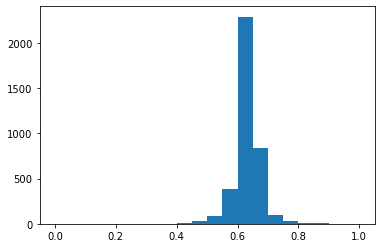

In [7]:
plt.hist(norm_data["Open%PriorClose"], bins=20)

(array([1362.,    0.,    0.,    0.,    0., 1138.,    0.,    0.,    0.,
        1272.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

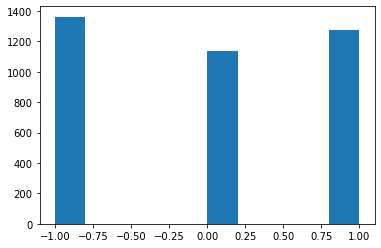

In [8]:
plt.hist(labels)

In [9]:
# Splitting training data to train and test data
train_data, test_data, train_labels, test_labels = train_test_split(
    norm_data, labels, test_size=0.2, shuffle=False)

## Take a look at the data sets
print("train_data:", train_data.shape)
print("train_labels:", train_labels.shape)
print("test_data:", test_data.shape)
print("test_labels:", test_labels.shape)

train_data: (3017, 47)
train_labels: (3017,)
test_data: (755, 47)
test_labels: (755,)


(array([255.,   0.,   0.,   0.,   0., 216.,   0.,   0.,   0., 284.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

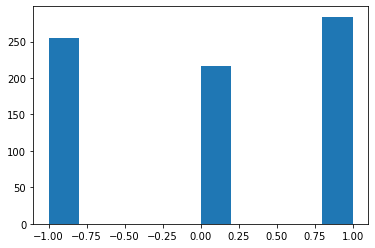

In [10]:
plt.hist(test_labels)

## Logistic Regression Model

In [34]:
## Logistic Regression model, feature select using L2 regularization
print("Logistic Regression Model:\n")
print("{:>8}  {:>10}{:>10}".format("L2 c", "accuracy", "f1"))
print("-" * 30)

# Produce Logistic Regression models with various C values
c_values = [0.1, 1, 10, 100, 500, 1000, 2500, 5000, 7000, 8000, 9000, 10000, 20000]
best_c, best_f1 = 0, 0

for c in c_values:
    lr_model = LogisticRegression(C=c, solver="liblinear")
    lr_model.fit(train_data, train_labels)
    accuracy = lr_model.score(test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lr_model.predict(test_data), average='weighted')
    print("{:>8}  {:10.4f}{:10.4f}".format(c, accuracy, f1))
    if f1 > best_f1:
        best_c = c
        best_f1 = f1 

print("\nBest f1 score of {:.4f} at C={}".format(best_f1, best_c))
c_l2 = best_c

Logistic Regression Model:

    L2 c    accuracy        f1
------------------------------
     0.1      0.3947    0.3923
       1      0.4252    0.4238
      10      0.4252    0.4242
     100      0.4212    0.4191
     500      0.4212    0.4198
    1000      0.4238    0.4225
    2500      0.4252    0.4245
    5000      0.4278    0.4279
    7000      0.4252    0.4251
    8000      0.4278    0.4279
    9000      0.4212    0.4215
   10000      0.4238    0.4240
   20000      0.4199    0.4201

Best f1 score of 0.4279 at C=8000


### Take a look at the classification report

              precision    recall  f1-score   support

        Sell       0.36      0.37      0.37       255
        Hold       0.43      0.49      0.46       216
         Buy       0.48      0.41      0.44       284

    accuracy                           0.42       755
   macro avg       0.42      0.42      0.42       755
weighted avg       0.42      0.42      0.42       755

[[ 95  81  79]
 [ 64 106  46]
 [106  62 116]]


(array([265.,   0.,   0.,   0.,   0., 249.,   0.,   0.,   0., 241.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

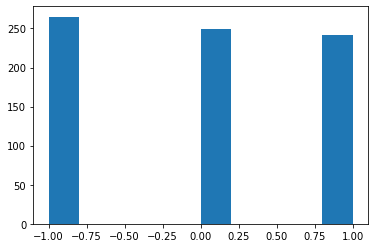

In [173]:
lr_model = LogisticRegression(C=c, solver="liblinear")

# Look at diagnostic reports
lr_model.fit(train_data, train_labels)
pred_labels = lr_model.predict(test_data)
score=lr_model.score(test_data, test_labels)
target_names = ['Sell', 'Hold', 'Buy']

print(classification_report(test_labels, pred_labels, target_names = target_names) )
print(confusion_matrix(test_labels, pred_labels))
plt.hist(pred_labels)

### Examine feature coefficients of best model with L2 regularization

In [16]:
## Get the top features from the model
indices, features, sell_weights, hold_weights, buy_weights = [], [], [], [], []
indices.extend(np.argsort(-lr_model.coef_[2]))

for i in indices:
    features.append(train_data.columns[i])
    sell_weights.append(lr_model.coef_[0][i])
    hold_weights.append(lr_model.coef_[1][i])
    buy_weights.append(lr_model.coef_[2][i])
    
## Set up table to print results
print("Features from the Logistic Regression Model with Weights:\n")
print("{:>20}{:>20}{:>20}{:>20}".format("Features", "Sell Weight", "Hold Weight", "Buy Weight"))
print("-" * 80)

## Print the features along with weights
for i in range(int(len(features))):
        print("{:>20}{:20.4f}{:20.4f}{:20.4f}"
              .format(features[i], sell_weights[i], hold_weights[i], buy_weights[i]))

Features from the Logistic Regression Model with Weights:

            Features         Sell Weight         Hold Weight          Buy Weight
--------------------------------------------------------------------------------
              SMA30%            -13.7130             -2.9650             23.1857
          Close%High            -13.4553            -20.6613             17.8534
                S3C%             -7.2236            -16.5634             14.7186
              EMA50%            -18.8826             12.3003             13.0050
              SMA15%            -11.9443              6.4298             12.7218
               EMA5%             29.2594            -59.2484              8.5792
              SMA50%             -9.5475              5.5826              8.5632
              SMA10%            -12.0744             10.5878              8.2889
              SMA20%             -0.7912              1.9534              4.4256
     Open%PriorClose            -12.5565          

## Integrate with Backtesting

In [215]:
def generate_lrmodel(ticker, model_timeframe="16y", 
                     metric="N5D_Return_Delayed%", buy_threshold=0.01, sell_threshold=-0.002):
    """
    Generate a logistic regression model for a ticker.
    model_timeframe is the timeframe where the model gets trained on.
    metric is the return metric the model is basing its labels on.
    """
    
    # Get model data
    data = yf.Ticker(ticker).history(period="16y")
    norm_data, labels = generate_model_data(data, metric, buy_threshold, sell_threshold)
    
    # Splitting training data to train and test data
    train_data, test_data, train_labels, test_labels = train_test_split(
        norm_data, labels, test_size=0.2, shuffle=False)

    ## Logistic Regression model, feature select using L2 regularization
    print("Logistic Regression Model:\n")
    print("{:>8}  {:>10}{:>10}".format("L2 c", "accuracy", "f1"))
    print("-" * 30)

    # Produce Logistic Regression models with various C values
    c_values = [0.1, 0.5, 1, 2, 5, 10, 100, 500, 1000, 2500, 5000, 7000, 8000]
    best_c, best_f1 = 0, 0

    for c in c_values:
        lr_model = LogisticRegression(C=c, solver="liblinear")
        lr_model.fit(train_data, train_labels)
        accuracy = lr_model.score(test_data, test_labels)
        f1 = metrics.f1_score(test_labels, lr_model.predict(test_data), average='weighted')
        print("{:>8}  {:10.4f}{:10.4f}".format(c, accuracy, f1))
        if f1 > best_f1:
            best_c = c
            best_f1 = f1 

    print("\nBest f1 score of {:.4f} at C={}".format(best_f1, best_c))
    c_l2 = best_c
    
    # Get the best model results
    lr_model = LogisticRegression(C=best_c, solver="liblinear")
    lr_model.fit(train_data, train_labels)
    """
    accuracy = lr_model.score(test_data, test_labels)
    f1 = metrics.f1_score(test_labels, lr_model.predict(test_data), average='weighted')
    print("Accuracy:", accuracy, "F1:", f1)
    """
    
    # Signals based on model results
    signal_data = normalize_features(add_features(data).tail(252*7)) #last 7 years
    signals = lr_model.predict(signal_data)
    
    # Generate output data
    output_data = data.tail(252*7).copy()
    output_data['LR_Signal'] = signals
    
    return lr_model, output_data

In [209]:
def LR_SIGNAL(data):
    return data['LR_Signal']

In [212]:
class LogReg_Signal(Strategy): 
    # Define parameters of the strategy
    buy_signal = 1
    sell_signal = -1
    long_only = 1
    
    def init(self):
        # Compute signal
        self.lr_sig = self.I(LR_SIGNAL, self.data)
        
    def next(self):
        # If RSI enters oversold territory
        if self.lr_sig == self.buy_signal:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If RSI enters overbought territory
        elif self.lr_sig == self.sell_signal:
            self.position.close()
            if self.long_only == 0:
                self.sell()

In [222]:
model, signal_data = generate_lrmodel("SPY", buy_threshold=0.01, sell_threshold=-0.01)

Logistic Regression Model:

    L2 c    accuracy        f1
------------------------------
     0.1      0.4808    0.4112
     0.5      0.4954    0.4371
       1      0.4954    0.4402
       2      0.4834    0.4292
       5      0.4874    0.4341
      10      0.4874    0.4350
     100      0.4742    0.4233
     500      0.4728    0.4215
    1000      0.4702    0.4167
    2500      0.4728    0.4202
    5000      0.4702    0.4180
    7000      0.4755    0.4245
    8000      0.4781    0.4270

Best f1 score of 0.4402 at C=1


In [224]:
# Specify data timeframe and strategy to test
# Get data from Yahoo
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
data = signal_data
strategy = LogReg_Signal

# Run backtesting
bt = Backtest(data, strategy, cash=1_000_000, commission=0)
stats = bt.run()

# Display stats and plot results
print(stats)
bt.plot()

Start                     2014-03-19 00:00:00
End                       2021-03-19 00:00:00
Duration                   2557 days 00:00:00
Exposure Time [%]                   96.598639
Equity Final [$]               2647336.471078
Equity Peak [$]                2688640.922982
Return [%]                         164.733647
Buy & Hold Return [%]              139.923544
Return (Ann.) [%]                   14.921505
Volatility (Ann.) [%]               17.603103
Sharpe Ratio                         0.847663
Sortino Ratio                        1.349704
Calmar Ratio                         0.840151
Max. Drawdown [%]                  -17.760511
Avg. Drawdown [%]                   -1.469612
Max. Drawdown Duration      294 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                                   28
Win Rate [%]                        71.428571
Best Trade [%]                      47.928396
Worst Trade [%]                    -12.188794
Avg. Trade [%]                    

### Export file to CSV

In [225]:
## tickers we will pre-generate model results for
tickers = ['SPY', 'QQQ', 'EEM', 'AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'TSLA']

## Export to csv if easier to process
for ticker in tickers:
    model, signal_data = generate_lrmodel(ticker, buy_threshold=0.01, sell_threshold=-0.01)
    signal_data.to_csv("lr_signal_data/" + ticker + "_lr_signal.csv")

Logistic Regression Model:

    L2 c    accuracy        f1
------------------------------
     0.1      0.4808    0.4112
     0.5      0.4954    0.4371
       1      0.4954    0.4402
       2      0.4834    0.4292
       5      0.4874    0.4341
      10      0.4874    0.4350
     100      0.4742    0.4233
     500      0.4728    0.4215
    1000      0.4702    0.4167
    2500      0.4728    0.4202
    5000      0.4702    0.4180
    7000      0.4755    0.4245
    8000      0.4781    0.4270

Best f1 score of 0.4402 at C=1


FileNotFoundError: [Errno 2] No such file or directory: 'lr_signal_data/SPY_lr_signal.csv'

In [206]:
stock = yf.Ticker("TSLA")
stock.info["beta"]

2.06013